<a href="https://colab.research.google.com/github/GaneshkumarPatel/Regression/blob/master/Self_Project_Regression_using_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Business Objective**

The client in this case study is an insurance company in the healthcare industry. One of their main areas of focus is the cost of future insurance claims. They would like to understand the factors that lead to higher healthcare costs and develop a predictive model to prepare for future claims and help manage their risk. To provide a more targeted cost prediction, you will build a model for each of the four regions where the company's policyholders reside.

# **Data Overview**

The data set consists of 1,338 policyholders with 7 attributes that describe their health and demographic information, including their age, gender, BMI, and smoking status. The data set also contains the US region each beneficiary is located in: Southwest, Southeast, Northwest, and Northeast. Our target variable is the total claim amount, charges, that were billed to the insurance company.



**Columns**

**age:** age of primary beneficiary

**sex:** insurance contractor gender, female, male

**bmi:** Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

**children:** Number of children covered by health insurance / Number of dependents

**smoker:** Smoking

**region:** the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

**charges:** Individual medical costs billed by health insurance

# **Tasks To Do**

*   Perform Exploratory Data Analysis
*   Create  XGboost model and a model using Artificial Neural Network.
*   Compare the differences.
*   Explain the model using SHAP.
*   Is it a good practice to use Artificial Neural Network for a simple problem? Justify your answers using this problem dataset as a reference.




In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [23]:
path='/content/drive/MyDrive/DL PROJECTS/'

In [24]:
insurance_df=pd.read_csv(path+'insurance.csv')
insurance_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [25]:
insurance_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [26]:
# checking for null values
insurance_df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

from above it is clear that we dont have any null values

In [27]:
# checking for duplicate values
insurance_df[insurance_df.duplicated()]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


In [28]:
# dropping duplicate values

insurance_df.drop_duplicates(inplace=True)

In [29]:
insurance_df.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


In [30]:
insurance_df.describe(include='object')

,sex,smoker,region
count,1337,1337,1337
unique,2,2,4
top,male,no,southeast
freq,675,1063,364


#**EDA**

**1. Is there relationship between BMI and claim amount?**

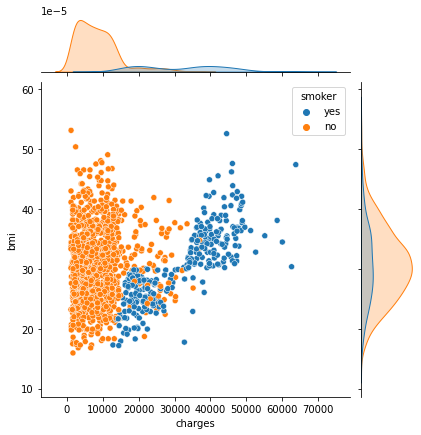

In [31]:
sns.jointplot(x=insurance_df["charges"], y=insurance_df["bmi"], kind='scatter',hue=insurance_df.smoker)

plt.show()

There are NO replationships between BMI and claim amount but has clear two natural clusters with respect to smoker class

 **2. Is there relationship between gender and claim amount?**

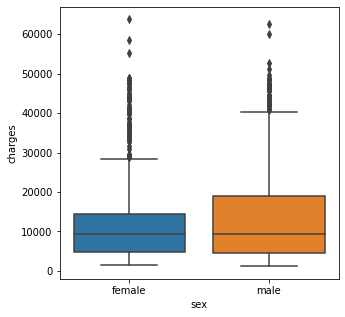

In [32]:
plt.figure(figsize = (5, 5))
sns.boxplot(x = 'sex', y = 'charges',  data = insurance_df)
plt.show()

 On average claims from male and female are the same with slightly bigger proportion of higher amounts for male

**3. Is there relationship between region and claim amount?**

<function matplotlib.pyplot.show>

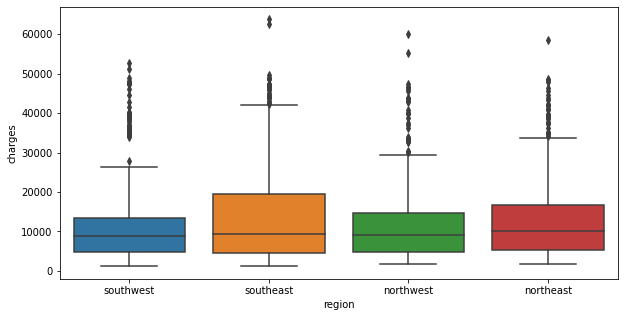

In [33]:
plt.figure(figsize = (10, 5))
sns.boxplot(x = 'region', y = 'charges',  data = insurance_df)
plt.show

On average claims from regions are the same with slightly bigger proportion of higher amounts from Southeast

**4. Is there relationships between claim amount between smokers and non-smokers?**

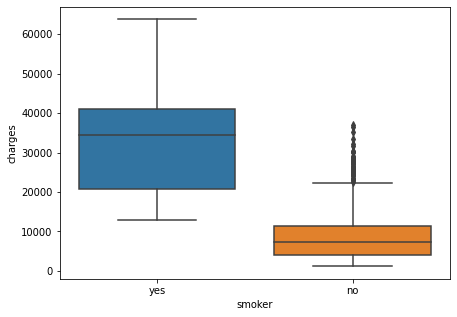

In [34]:
plt.figure(figsize = (7, 5))
sns.boxplot(x = 'smoker', y = 'charges',  data = insurance_df)

There is a strong replationship between smokers and non-smokers with claims from smokers being much higher.

**Lets have a look on pairplot with respect to smokers column**

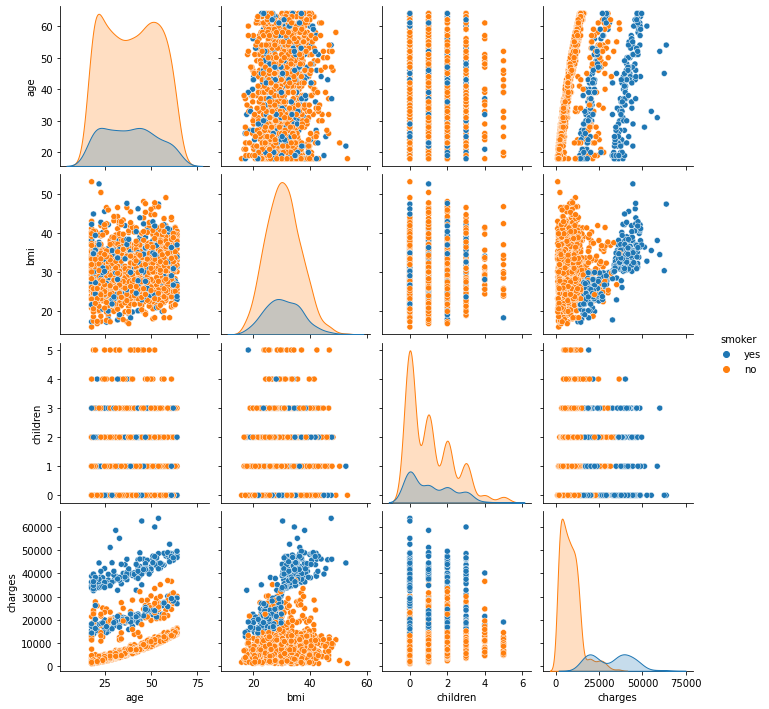

In [35]:
sns.pairplot(insurance_df,diag_kind='kde',hue='smoker')

W can see kde distributions for each column smoker class clearly seperates out the distributions very well.this beacomes very helpful in regression for tree based ressors.

#Feature engineering

In [36]:
# we will derive new column including categories as age groups of policy holders

insurance_df['age_group'] = np.nan
insurance_df.loc[insurance_df.age < 20, 'age_group'] = 'younger'
insurance_df.loc[(insurance_df.age >= 20) & (insurance_df.age < 35), 'age_group'] = 'young'
insurance_df.loc[(insurance_df.age >= 35) & (insurance_df.age < 55), 'age_group'] = 'middle age'
insurance_df.loc[(insurance_df.age >= 55), 'age_group'] = 'old'

BMI is used to broadly define different weight groups in adults 20 years old or older. The same groups apply to both men and women.

**Underweight: BMI is less than 18.5**

**Normal weight: BMI is 18.5 to 24.9**

**Overweight: BMI is 25 to 29.9**

**Obese: BMI is 30 or more**

reference- google search


In [37]:
# we will derive a categorical column which includes bmi groups of policy holders based on general severity of bmi value

insurance_df['bmi_group'] = np.nan
insurance_df.loc[insurance_df.bmi< 18.5, 'bmi_group'] = 'Underweight'
insurance_df.loc[(insurance_df.bmi >= 18.5) & (insurance_df.bmi < 24.9), 'bmi_group'] = 'Normal weight'
insurance_df.loc[(insurance_df.bmi >= 24.9) & (insurance_df.bmi <= 29.9), 'bmi_group'] = 'Overweight'
insurance_df.loc[(insurance_df.bmi >30), 'bmi_group'] = 'Obese'


**Does our newly created features have any effect on charges?**

 lets have a look for it...

<function matplotlib.pyplot.show>

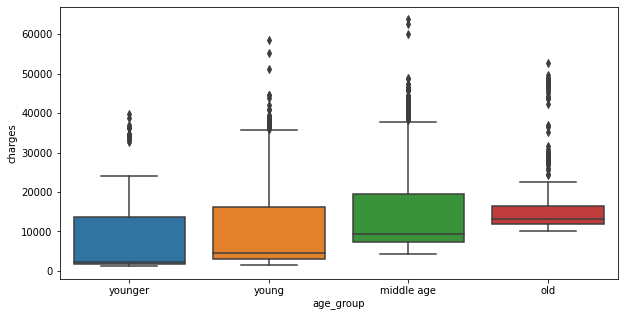

In [38]:
plt.figure(figsize = (10, 5))
sns.boxplot(x = 'age_group', y = 'charges',  data = insurance_df)
plt.show

We can see age groups significantly describes charges paid for each groups. Age groups will help in are separating out charges distribution significantly

<function matplotlib.pyplot.show>

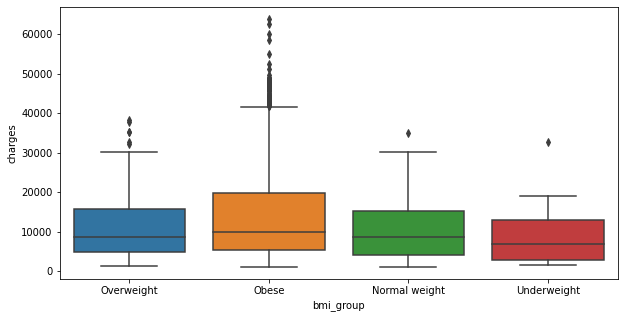

In [39]:
plt.figure(figsize = (10, 5))
sns.boxplot(x = 'bmi_group', y = 'charges',  data = insurance_df)
plt.show

over bmi groups charges distribution don't seem to vary significanty but till obse group has maximum charges and it seems obvious having large bmi value generallyleads to health issues.

# Lets find out pearson corelation using corr() method and heatmap visualisation

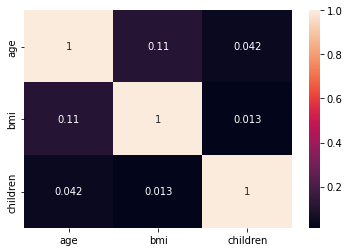

In [40]:
cor=insurance_df.drop('charges',axis=1).corr()
sns.heatmap(cor,annot=True)

we can see that children column doesn't have significant corelation with charges. we can neglect this feature for sure if we are using linear mosels and if we can't get better accuracy. for now we kept it as it is as we were approaching for xgboost which might found any non linear relation with this column

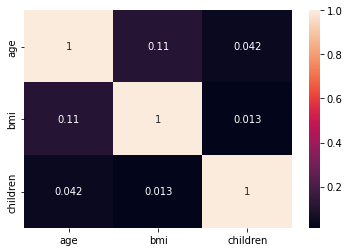

In [41]:
cor=insurance_df.drop('charges',axis=1).corr()
sns.heatmap(cor,annot=True)

our all numerical columns does't have any corelation value greater than 0.5 so we can surely say that there is no multicolinearity in our dataset. we can keep the features as it is

In [42]:
#we will change dtypes and convert the categorical values in dummies
insurance_df.dtypes.value_counts()

object     5
int64      2
float64    2
dtype: int64

We do have five columns which are categorical, we will encode those cateories and get encoded category columns using get dummies function

In [43]:
insurance_df1=pd.get_dummies(insurance_df,drop_first=True)

# Bulding Models



**Train test split and scaling predictors to have all numerical columns to act as having same unit**

In [44]:
#dividing daata into features(X) and label(y)
X, y = insurance_df1.drop('charges',axis=1),insurance_df1['charges']

In [45]:
#loading required libraries and performing train test split by 80-20 ratio
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.model_selection import cross_val_score,ShuffleSplit,cross_val_predict

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
print('train features shape:',x_train.shape)
print('test features shape:',x_test.shape)
print('train label shape:',y_train.shape)
print('test label shape:',y_test.shape)

train features shape: (1069, 14)
test features shape: (268, 14)
train label shape: (1069,)
test label shape: (268,)


In [46]:
#performing standard scaling 

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)

In [47]:
# Lets define a function for Evaluation metrics so that we can reuse it again and again
def print_metrics(actual,prediction,model=''):

  print(f"{model} R2    :", r2_score(actual,prediction))
  print(f"{model} MAE   :", mean_absolute_error(actual,prediction))
  print(f"{model} MSE   :", mean_squared_error(actual,prediction))
  print(f"{model} RMSE  :", np.sqrt(mean_squared_error(actual,prediction)))

**1. Random Forest model**

Random forest is a commonly-used machine learning algorithm which combines the output of multiple decision trees to reach a single result. Its ease of use and flexibility have fueled its adoption, as it handles both classification and regression problems.

In [49]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(criterion='squared_error',random_state=100,n_estimators=200,max_depth=8).fit(x_train,y_train)
y_train_pred_rf = cross_val_predict(rf,x_train,y_train,cv=5)
y_pred_rf=rf.predict(x_test)
print_metrics((y_train),(y_train_pred_rf),'rf_train')
print_metrics((y_test),(y_pred_rf),'rf_test')
print("Adjusted R2 : ",1-(1-r2_score((y_test), (y_pred_rf)))*((x_test.shape[0]-1)/(x_test.shape[0]-x_test.shape[1]-1)))

rf_train R2    : 0.832731764374143
rf_train MAE   : 2801.204118202374
rf_train MSE   : 24174094.19937006
rf_train RMSE  : 4916.715794040781
rf_test R2    : 0.8945191099355894
rf_test MAE   : 2525.4200294011107
rf_test MSE   : 16303575.60879651
rf_test RMSE  : 4037.768642306851
Adjusted R2 :  0.8886822227383493


**2. XGBOOST Regressor**

XGBoost stands for “Extreme Gradient Boosting”. XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements Machine Learning algorithms under the Gradient Boosting framework. It provides a parallel tree boosting to solve many data science problems in a fast and accurate way.

In [50]:
#loading libraries
from xgboost import XGBRegressor

xg_reg = XGBRegressor(learning_rate = 0.02, max_depth = 5, n_estimators = 200)
xg_reg.fit(x_train,y_train)


y_train_pred_xg = cross_val_predict(xg_reg,x_train,y_train,cv=5)
y_pred_xg=xg_reg.predict(x_test)
print_metrics((y_train),(y_train_pred_xg),'XG_train')
print_metrics((y_test),(y_pred_xg),'XG_test')
print("Adjusted R2 : ",1-(1-r2_score((y_test), (y_pred_xg)))*((x_test.shape[0]-1)/(x_test.shape[0]-x_test.shape[1]-1)))

[02:09:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:09:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:09:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:09:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:09:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:09:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XG_train R2    : 0.8400788262674206
XG_train MAE   : 2596.6810439468986
XG_train MSE   : 23112275.345167723
XG_train RMSE  : 4807.522786754913
XG_test R2    : 0.901829212858336
XG_test MAE   : 2290.9745234574684
XG_test MSE   : 15173694.9

From above two results its clear that XGBOOST performing a bit good against the random forest 

**Hypertuning model we choose**

In [51]:

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)


param_grid = {
    'n_estimators' : np.arange(1,200,2),
    'max_depth': [3,4,5,6,7,8],
}

In [52]:
XG_tuned=RandomizedSearchCV(xg_reg, param_grid, cv=cv, n_iter = 10)

XG_tuned.fit(x_train,y_train)

[02:10:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:10:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:10:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:10:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:10:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:10:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:10:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:10:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.3, train_size=None),
                   estimator=XGBRegressor(learning_rate=0.02, max_depth=5,
                                          n_estimators=200),
                   param_distributions={'max_depth': [3, 4, 5, 6, 7, 8],
                                        'n_estimators': array([  1,   3,   5,   7,   9,  11,  13,  15,  17,  19,  21,  23,  25,
        27,  29,  31,  33,  35,  37,  39,  41,  43,  45,  47,  49,  51,
        53,  55,  57,  59,  61,  63,  65,  67,  69,  71,  73,  75,  77,
        79,  81,  83,  85,  87,  89,  91,  93,  95,  97,  99, 101, 103,
       105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129,
       131, 133, 135, 137, 139, 141, 143, 145, 147, 149, 151, 153, 155,
       157, 159, 161, 163, 165, 167, 169, 171, 173, 175, 177, 179, 181,
       183, 185, 187, 189, 191, 193, 195, 197, 199])})

In [96]:
y_train_pred_tuned_xg = XG_tuned.predict(x_train)
y_pred_tuned_xg=XG_tuned.predict(x_test)
print_metrics((y_train),(y_train_pred_tuned_xg),'tuned_xg_train')
print_metrics((y_test),(y_pred_tuned_xg),'tuned_xg_test')
print("Adjusted R2 : ",1-(1-r2_score((y_test), (y_pred_tuned_xg)))*((x_test.shape[0]-1)/(x_test.shape[0]-x_test.shape[1]-1)))

tuned_xg_train R2    : 0.8729300843052539
tuned_xg_train MAE   : 2208.6560731149657
tuned_xg_train MSE   : 18364515.536480926
tuned_xg_train RMSE  : 4285.38394271516
tuned_xg_test R2    : 0.9038537285676642
tuned_xg_test MAE   : 2167.680467649108
tuned_xg_test MSE   : 14860777.19711852
tuned_xg_test RMSE  : 3854.967859414462
Adjusted R2 :  0.8985333815318828


After hypertuning we get more good results not just with r2 score but we can see RMSE and MAE values are drastically dropped

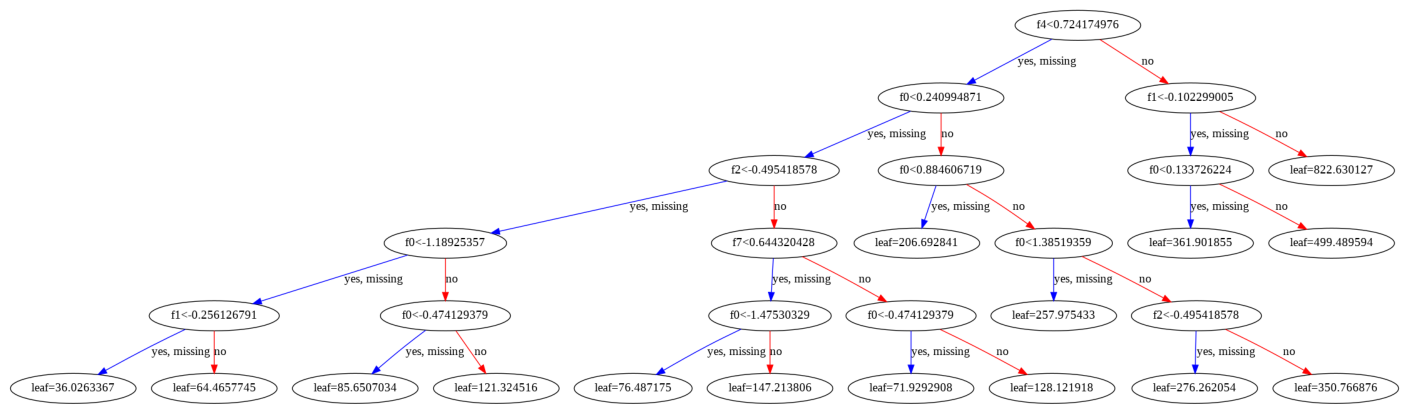

In [64]:
# Plotting Xgboost trees
import xgboost as xgb

xgb.plot_tree(xg_reg,num_trees=0)
fig = plt.gcf()
fig.set_size_inches(25, 15)

plt.show()

**What if we have used neural Networks rather than traditional ML approach?**

Lets have a glance of it 

#**Regression:** Using deep learning ANN technique

In [83]:
#Initializine the ANN
import tensorflow as tf
import keras
ann = keras.models.Sequential()

#add input_Layer_and_1st_Hidden_Layer
ann.add(keras.layers.Dense(units = 14, input_dim=14, activation= 'relu'))

#add_second_hidden_layer

ann.add(keras.layers.Dense(units = 128, activation= 'relu'))

# drop out layer will help in reducing the chances of overfitting
ann.add(keras.layers.Dropout(0.2))

#add_third_hidden_layer
ann.add(keras.layers.Dense(units = 4 ,activation = 'relu'))

#add_Output_layer
ann.add(keras.layers.Dense(units = 1, activation = 'linear'))

In [84]:
#compiling the layers we defined earlier
ann.compile(optimizer ='adam' ,loss ='mean_squared_error')

In [85]:
%%time
#train_ANN

ann.fit(x_train,y_train, batch_size = 15,epochs =150)

Epoch 1/150
72/72 [==============================] - 1s 3ms/step - loss: 322467776.0000
Epoch 2/150
72/72 [==============================] - 0s 3ms/step - loss: 321874016.0000
Epoch 3/150
72/72 [==============================] - 0s 3ms/step - loss: 318241760.0000
Epoch 4/150
72/72 [==============================] - 0s 3ms/step - loss: 305139872.0000
Epoch 5/150
72/72 [==============================] - 0s 2ms/step - loss: 273909824.0000
Epoch 6/150
72/72 [==============================] - 0s 2ms/step - loss: 222200144.0000
Epoch 7/150
72/72 [==============================] - 0s 2ms/step - loss: 160836624.0000
Epoch 8/150
72/72 [==============================] - 0s 3ms/step - loss: 114070152.0000
Epoch 9/150
72/72 [==============================] - 0s 2ms/step - loss: 89678888.0000
Epoch 10/150
72/72 [==============================] - 0s 3ms/step - loss: 73119568.0000
Epoch 11/150
72/72 [==============================] - 0s 3ms/step - loss: 62163796.0000
Epoch 12/150
72/72 [=============

In [97]:
 y_train_pred_ann = ann.predict(x_train)
y_pred_ann = ann.predict(x_test)

print_metrics((y_train),(y_train_pred_ann),'ann_train')
print_metrics((y_test),(y_pred_ann),'ann_test')
print("Adjusted R2 : ",1-(1-r2_score((y_test), (y_pred_ann)))*((x_test.shape[0]-1)/(x_test.shape[0]-x_test.shape[1]-1)))

ann_train R2    : 0.8615761612303677
ann_train MAE   : 2488.954143427649
ann_train MSE   : 20005417.677390892
ann_train RMSE  : 4472.741628731856
ann_test R2    : 0.9092718101642566
ann_test MAE   : 2343.6111749237702
ann_test MSE   : 14023335.430076795
ann_test RMSE  : 3744.77441644711
Adjusted R2 :  0.9042512779203815


here we get ANN has small improvement on r2 score with ann but other metrics are not improved if we compare it with xgboost tuned model.



#**Explainability of model**

In [89]:
##installing shap library
!pip install shap

In [90]:
import shap
# Create object that can calculate shap values
explainer = shap.TreeExplainer(xg_reg)
# Calculate Shap values
shap_values = explainer.shap_values(x_test)

In [91]:
#assigning column names variable
features=X.columns

**SHAP Feature importance**

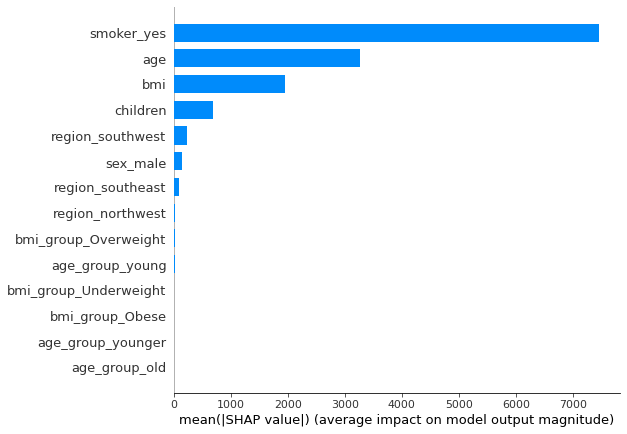

In [92]:
#plotting summary plots explaing feature importance in predictin target
shap.summary_plot(shap_values, x_test, feature_names=features, plot_type="bar")

Feature importance here calculated by SHAP values (features with large absolute Shapley values are important) and feature importance in tree based algorithms the computed  as mean and standard deviation of accumulation of the impurity decrease within each tree 

**As we stated in EDA smoker class will be very important feature and here we can see in shaplet feature importance chart smoker class is topmost important feature**


**SHAP Summary Plot**

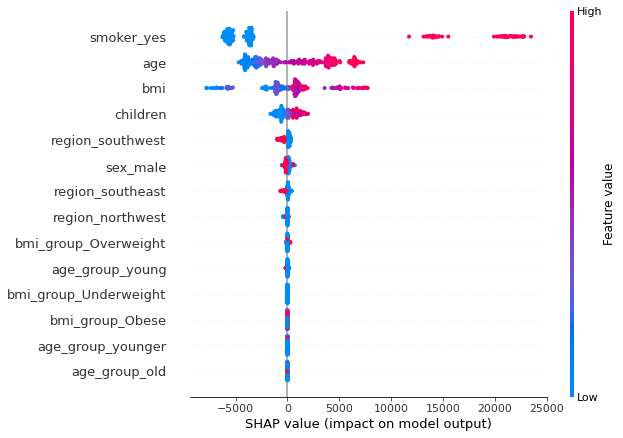

In [93]:
shap.summary_plot(shap_values, x_test, feature_names=features)

The summary plot combines feature importance with feature effects. Each point on the summary plot is a Shapley value of an instance per feature. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value of each instance. The color represents the value of the feature from low to high. 

**What we get to know from above plot**

1. smoker_yes variable is an important variable. Higher the value as shown in red to predict charges on higher side.
(which has 0 and 1 values where 1 stands for smoking yes record)

2. Higher Age values shown in red colour helps to predict charges on higher side.

In the summary plot, we see first indications of the relationship between the value of a feature and the impact on the prediction. But to see the exact form of the relationship, we have to look at SHAP dependence plots.

**Dependence plot**

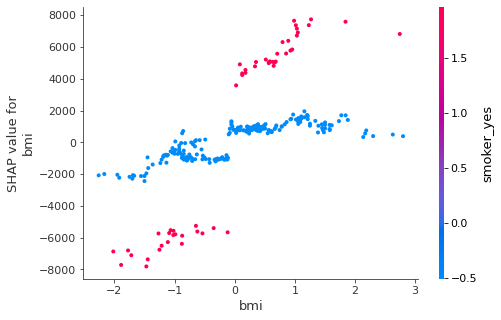

In [94]:
shap.dependence_plot(1, shap_values, x_test, feature_names=features)

The method considers all instances and gives a statement about the global relationship of a feature with the predicted outcome.

From above plot we can conclude relation in the way like predicting higher charges bmi and smoker higher values responsible. lower bmi and higher smoker valuesare responsible for predicting lower charges.

**Force Plot**

In [95]:
# Initialize JavaScript visualizations in notebook environment
shap.initjs()
i = 18
shap.force_plot(explainer.expected_value, shap_values[i], x_test[i], feature_names = features)

The above plot explains how did we reach to prection means which variable contributing in what amount to get that prediction.

For i'th no of prediction smoker and bmi values are more responsible to force the prediction value higher side, when age variable forcing towards lower side for this particular prediction


# Is it a good practice to use Artificial Neural Network for a simple problem?

Here's a catch before using ANN, we should generally be aware for the fact that,

1. ANN is rarely used for predictive modelling. The reason being that Artificial Neural Networks (ANN) usually tries to over-fit the relationship. 

2. For each observation ANN does multiple re-calibrations for each linkage weights. Hence, the time taken by the algorithm rises much faster than other traditional algorithm for the same increase in data volume.

3. Artificial Neural Networks (ANN) have many different coefficients, which it can optimize. Hence, it can handle much more variability as compared to traditional models.

4. ANN will be able to memorize every single call. Hence, it is a kind of machine learning technique which has enormous memory. But it does not work well in case where scoring population is significantly different compared to training sample.

For same reason, it works very well in cases of image recognition and voice recognition.

In our usecase we can see the model has 

Reference: https://www.analyticsvidhya.com/blog/2014/10/ann-work-simplified/